# Model training

In [1]:
import os
import random
import numpy as np
import pandas as pd
import pickle
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import cv2
import tensorflow as tf

from sklearn.metrics import classification_report, confusion_matrix
from tensorflow import keras
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Input, GlobalAveragePooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler

print('Tensorflow: ', tf.__version__)
print('Opencv: ', cv2.__version__)

Tensorflow:  2.4.1
Opencv:  4.5.2


In [2]:
DATASET_PATH = '../dataset/'
CSV_PATH = '../'
MODELS_PATH = '../models/'
MODEL_NAME = 'bs_xception_model_clahe_gb'

In [3]:
label_df = pd.read_csv(os.path.join(CSV_PATH, 'bs_labels.csv'))
label_df.head(10)

,file_path,file_name,label,subset
0,wasp/1331787019_ca513a7acf_n.jpg,1331787019_ca513a7acf_n.jpg,wasp,train
1,bee/14322267704_2ac34a2af2_n.jpg,14322267704_2ac34a2af2_n.jpg,bee,train
2,wasp/7382817412_b5a0f8c899_w.jpg,7382817412_b5a0f8c899_w.jpg,wasp,train
3,wasp/4250759545_eb707b1145_n.jpg,4250759545_eb707b1145_n.jpg,wasp,train
4,other_insect/insect3.jpg,insect3.jpg,other_insect,train
5,other_insect/insect_image_204.jpg,insect_image_204.jpg,other_insect,train
6,other_insect/8542836797_477176edca_n.jpg,8542836797_477176edca_n.jpg,other_insect,train
7,bee/1324904081_75fdbb7ace_n.jpg,1324904081_75fdbb7ace_n.jpg,bee,train
8,bee/15063164899_4b3d4e7082_w.jpg,15063164899_4b3d4e7082_w.jpg,bee,train
9,wasp/6103665305_b52694b9a9_m.jpg,6103665305_b52694b9a9_m.jpg,wasp,train


In [4]:
train_df = label_df[label_df['subset'] == 'train']
val_df = label_df[label_df['subset'] == 'validation']
test_df = label_df[label_df['subset'] == 'test']

In [5]:
NUM_CLASSES = 4
TARGET_SIZE = (299, 299)
BATCH_SIZE = 64
EPOCHS = 100

## Data augmentation

In [6]:
def apply_clahe_gb(img):
    grey_image = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    grey_image = np.uint8(grey_image)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img_clahe = clahe.apply(grey_image)
    img_gaussian = cv2.GaussianBlur(img_clahe, (5, 5), 0)
    img_gaussian = np.float32(img_gaussian)
    rgb_img = np.repeat(img_gaussian[..., np.newaxis], 3, -1)
    return rgb_img

In [7]:
train_datagen = ImageDataGenerator(rescale=1. / 255,
                                   rotation_range=25,
                                   zoom_range=0.1,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   brightness_range=[0.7, 1.3],
                                   horizontal_flip=True,
                                   preprocessing_function=apply_clahe_gb,
                                   fill_mode='nearest')

test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                            preprocessing_function=apply_clahe_gb)


train_generator = train_datagen.flow_from_dataframe(train_df,
                                                    directory=DATASET_PATH, 
                                                    x_col='file_path',
                                                    y_col='label',
                                                    class_mode='categorical',
                                                    target_size=TARGET_SIZE,
                                                    seed=42,
                                                    batch_size=BATCH_SIZE)

val_generator = test_datagen.flow_from_dataframe(val_df,
                                                 directory=DATASET_PATH, 
                                                 x_col='file_path',
                                                 y_col='label',
                                                 class_mode='categorical',
                                                 target_size=TARGET_SIZE,
                                                 shuffle=False,
                                                 batch_size=BATCH_SIZE)

Found 10122 validated image filenames belonging to 4 classes.
Found 1265 validated image filenames belonging to 4 classes.


## Model definition

In [8]:
input_ = Input(shape=(299, 299, 3))

base_model = Xception(
    weights='imagenet',
    include_top=False,
    input_tensor=input_,
)

base_model.trainable = False

base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [9]:
# Unfreeze the last 6 layers
for i in range(-6, 0):
    base_model.layers[i].trainable = True

In [10]:
layers = [(layer, layer.name, layer.trainable) for layer in base_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name',
                              'Layer Trainable']).tail(10)

,Layer Type,Layer Name,Layer Trainable
122,<tensorflow.python.keras.layers.convolutional....,conv2d_3,False
123,<tensorflow.python.keras.layers.pooling.MaxPoo...,block13_pool,False
124,<tensorflow.python.keras.layers.normalization_...,batch_normalization_3,False
125,<tensorflow.python.keras.layers.merge.Add obje...,add_11,False
126,<tensorflow.python.keras.layers.convolutional....,block14_sepconv1,True
127,<tensorflow.python.keras.layers.normalization_...,block14_sepconv1_bn,True
128,<tensorflow.python.keras.layers.core.Activatio...,block14_sepconv1_act,True
129,<tensorflow.python.keras.layers.convolutional....,block14_sepconv2,True
130,<tensorflow.python.keras.layers.normalization_...,block14_sepconv2_bn,True
131,<tensorflow.python.keras.layers.core.Activatio...,block14_sepconv2_act,True


In [11]:
custom_model = base_model.output
custom_model = GlobalAveragePooling2D()(custom_model)
custom_model = Dense(1024, activation='relu')(custom_model)
custom_model = Dropout(0.2)(custom_model)
custom_model = Dense(512, activation='relu')(custom_model)
custom_model = Dropout(0.2)(custom_model)
custom_model = Dense(128, activation='relu')(custom_model)
custom_model = Dropout(0.2)(custom_model)
custom_model = Dense(NUM_CLASSES, activation='softmax')(custom_model)

model = Model(base_model.input, custom_model)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

## Fitting optimization

In [12]:
es = EarlyStopping(monitor='val_accuracy',
                   patience=15,
                   restore_best_weights=True)

mc = ModelCheckpoint(filepath=MODELS_PATH + MODEL_NAME + '.h5',
                     monitor='val_accuracy',
                     mode='max',
                     save_best_only=True)

lr_start = 0.001
lr_decay = 0.9
lrs = LearningRateScheduler(lambda epoch: lr_start * np.power(lr_decay, epoch))

## Fit model

In [13]:
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_generator,
                    steps_per_epoch=train_generator.n // BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=val_generator,
                    validation_steps=val_generator.n // BATCH_SIZE,
                    callbacks=[es, mc, lrs])

Epoch 1/100
158/158 [==============================] - 1923s 12s/step - loss: 0.6957 - accuracy: 0.7280 - val_loss: 0.6940 - val_accuracy: 0.8191
Epoch 2/100
158/158 [==============================] - 1454s 9s/step - loss: 0.3890 - accuracy: 0.8630 - val_loss: 0.4402 - val_accuracy: 0.8520
Epoch 3/100
158/158 [==============================] - 1491s 9s/step - loss: 0.3390 - accuracy: 0.8758 - val_loss: 0.4070 - val_accuracy: 0.8569
Epoch 4/100
158/158 [==============================] - 1483s 9s/step - loss: 0.2722 - accuracy: 0.8983 - val_loss: 0.4419 - val_accuracy: 0.8462
Epoch 5/100
158/158 [==============================] - 1484s 9s/step - loss: 0.2500 - accuracy: 0.9099 - val_loss: 0.4597 - val_accuracy: 0.8660
Epoch 6/100
158/158 [==============================] - 1490s 9s/step - loss: 0.2041 - accuracy: 0.9224 - val_loss: 0.5024 - val_accuracy: 0.8561
Epoch 7/100
158/158 [==============================] - 1478s 9s/step - loss: 0.1827 - accuracy: 0.9408 - val_loss: 0.5159 - val_a

## Model history

In [14]:
with open(MODELS_PATH + MODEL_NAME + '_hist', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

In [15]:
history = pickle.load(open(MODELS_PATH + MODEL_NAME + '_hist', 'rb'))

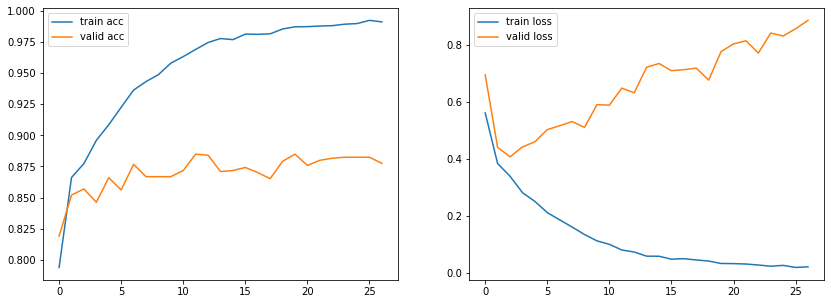

In [16]:
acc = history['accuracy']
val_acc = history['val_accuracy']

loss = history['loss']
val_loss = history['val_loss']

plt.figure(figsize=(14,5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='train acc')
plt.plot(val_acc, label='valid acc')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='train loss')
plt.plot(val_loss, label='valid loss')
plt.legend()

plt.show()